# MyGP Demo: Sine Function

## 0. Imports

In [116]:
%load_ext autoreload
%autoreload 2
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from mygp.gp import GP
import mygp.kernel as kernels  
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Generating toy data and constructing GP Model instance

In [117]:
# Base key
key = jr.PRNGKey(1234)

In [118]:
# Generate data
key, _ = jr.split(key, 2)
train_x = jnp.array([-4, -3, -2, -1, 1, 2, 3.7]).reshape(-1, 1)
sigma_n = 0.001
f = jnp.sin(train_x)
train_y  = jnp.sin(train_x) + sigma_n ** 2 * jr.normal(key, shape=train_x.shape)
X_s = jnp.linspace(-5, 5, 100).reshape(-1, 1)

In [119]:
# Initialize GP instance
sin_GP = GP(train_x, train_y, kernel=kernels.rbf, hyperparams={'sigma_f': 0.5, 'l': 0.3}, sigma_n=sigma_n)

## 2. Drawing noisy samples from the prior

(5, 100)


/var/folders/dc/6ng8g6b14dg84cqfwbrdk3nw0000gn/T/ipykernel_17547/1341727723.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = jnp.asarray(np.random.multivariate_normal(prior_mu.ravel(), prior_cov, 5))


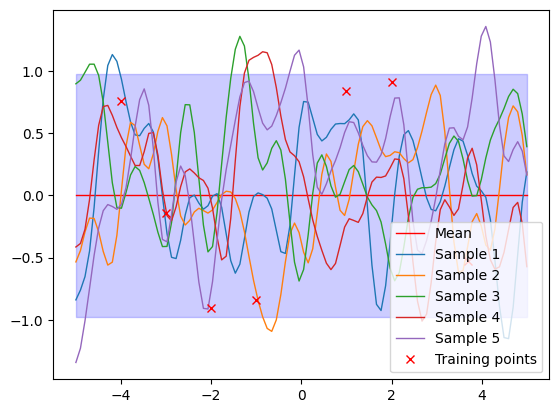

In [120]:
# Generate samples and print out the prior distribution
prior_mu, prior_cov = sin_GP.compute_prior_dist(X_s)
samples = jnp.asarray(np.random.multivariate_normal(prior_mu.ravel(), prior_cov, 5))
print(samples.shape)
sin_GP.plot(X_s=X_s, mu=prior_mu, cov=prior_cov, train_x=train_x, train_y=train_y, samples=samples)

## 3a. Computing the posterior directly and drawing samples

/var/folders/dc/6ng8g6b14dg84cqfwbrdk3nw0000gn/T/ipykernel_17547/126288771.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  post_samples = jnp.asarray(np.random.multivariate_normal(post_mu.ravel(), post_cov, 5))


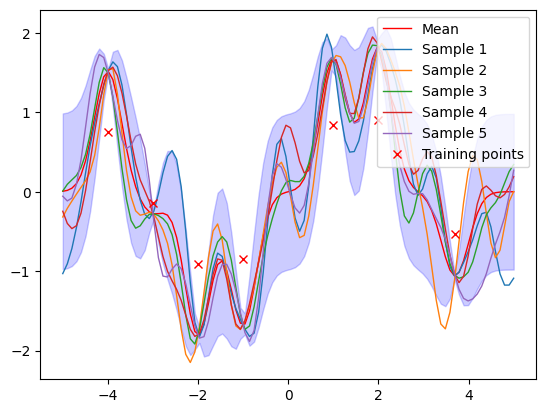

In [121]:
# Make predictions, and plot the posterior distribution
post_mu, post_cov = sin_GP.compute_post_dist(X_s=X_s)
post_samples = jnp.asarray(np.random.multivariate_normal(post_mu.ravel(), post_cov, 5))
sin_GP.plot(X_s=X_s, mu=post_mu, cov=post_cov, train_x=train_x, train_y=train_y, samples=post_samples)

## 3b. Generating posterior samples via pathwise conditioning

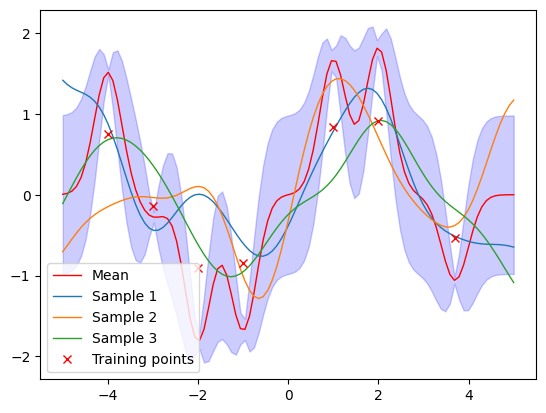

In [126]:
# Get posterior samples directly from .update()
keys = jr.split(key, 7)
key = keys[0]
post_samples_paths = [sin_GP.update(X_s=X_s, y=train_y, f=lambda x: sin_GP.prior_f(x, 1000, keys[i]), key=keys[i+1]) for i in range(1,6,2)]
sin_GP.plot(X_s=X_s, mu=post_mu, cov=post_cov, train_x=train_x, train_y=train_y, samples=post_samples_paths)

## 4. Training GP to find optimal hyperparameters

In [123]:
# Train the GP
num_epochs = 1000
print_every = 100
sin_GP.train(num_epochs=num_epochs, print_every=print_every)

Epoch 1: loss = 32.701
Epoch 101: loss = 14.712
Epoch 201: loss = 10.980
Epoch 301: loss = 9.494
Epoch 401: loss = 8.765
Epoch 501: loss = 8.351
Epoch 601: loss = 8.090
Epoch 701: loss = 7.915
Epoch 801: loss = 7.791
Epoch 901: loss = 7.699


In [124]:
sin_GP.train_state.params

FrozenDict({
    l: Array(0.8350719, dtype=float32),
    sigma_f: Array(0.75893366, dtype=float32),
    sigma_n: Array(0.17918144, dtype=float32),
})

/var/folders/dc/6ng8g6b14dg84cqfwbrdk3nw0000gn/T/ipykernel_17547/200491513.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  test_samples = jnp.asarray(np.random.multivariate_normal(test_mu.ravel(), test_cov, 5))


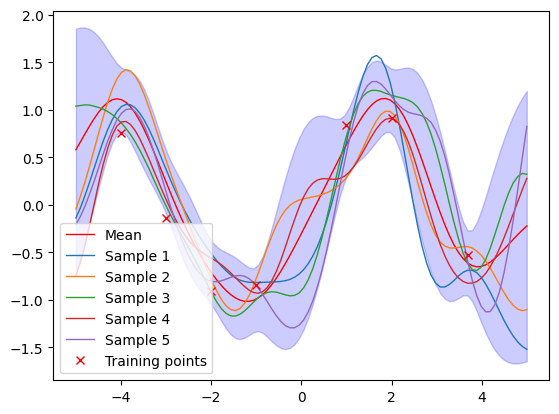

In [125]:
# Drawing samples from posterior after training loop and plotting
test_mu, test_cov = sin_GP.compute_post_dist(X_s=X_s)
test_samples = jnp.asarray(np.random.multivariate_normal(test_mu.ravel(), test_cov, 5))
sin_GP.plot(X_s=X_s, mu=test_mu, cov=test_cov, train_x=train_x, train_y=train_y, samples=test_samples)